In [12]:
# Downloading necessary dependencies
! pip install spacy pandas openpyxl -q
! python -m spacy download de_core_news_sm -q
! pip install ipywidgets -q
! pip install wordcloud -q

✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [13]:
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import ipywidgets as widgets
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import numpy as np

# Excel-Datei lesen
df = pd.read_excel(r'Stellenausschreibungen_2022_HES.xlsx')


In [3]:
df.describe().T

,count,unique,top,freq
Titel,626,563,Data Analyst (m/w/d),18
Unternehmen,626,503,Volkswagen AG,5
Text,626,623,Stellenbeschreibung\nAnstellungsart\nVollzeit\...,2
Unternehmen - 1. Buchstabe,626,30,A,73
6 Gruppen,6,6,Ende Teil 1,1
5 Gruppen,4,4,Ende Teil 1,1


In [4]:
df.head

<bound method NDFrame.head of                                                  Titel  \
0    (Junior) Controller - Financial Planning & Ana...   
1                           (Junior) Sales Ops Analyst   
2                         Web Analytics Expert (m/w/d)   
3              Data Analysis / Datenauswertung (m/w/d)   
4         Lead Data Analyst/Consultant (m/w/d), Berlin   
..                                                 ...   
621  (Senior) Data Analyst / Data Manager (w/m/d) C...   
622           Senior Consultant Data Analytics (m/w/d)   
623     (Senior) Business Analyst (m/w/d) Credit Lines   
624              Business Analyst (m/w/d) Credit Lines   
625                   Service Business Analyst (m/w/d)   

                   Unternehmen  \
0                         1NCE   
1                         1NCE   
2                  21TORR GmbH   
3    3P Services GmbH & Co. KG   
4     9 friendly white rabbits   
..                         ...   
621         ZEIT Verlagsgruppe   
6

In [5]:
# Lade das deutsche Spacy-Modell und die Stopwörter-Liste
nlp = spacy.load("de_core_news_sm", disable=["tagger", "parser", "ner"])
stopwords = nlp.Defaults.stop_words

# Methoden zur Tokenisierung mit und ohne stopwords
def tokenize_text(text):
    doc = nlp(text)
    return [token.text for token in doc]

def tokenize_without_stopwords(text):
    doc = nlp(text)
    return [token.text for token in doc if not (token.is_stop or token.is_punct)]

def tokenize_only_stopwords(text):
    doc = nlp(text)
    return [token.text for token in doc if token.is_stop]

In [6]:
# Analyse der Spalte "Text"
df["tokens"] = df["Text"].apply(tokenize_text)
df["tokens_without_stopwords"] = df["Text"].apply(tokenize_without_stopwords)
df["tokens_stopwords_only"] = df["Text"].apply(tokenize_only_stopwords)

df["without_stopwords"] = df["tokens_without_stopwords"].apply(lambda x: " ".join(x))
df["stopwords_only"] = df["tokens_stopwords_only"].apply(lambda x: " ".join(x))

# Analyse: Hier die Anzahl der Wörter ohne Stoppwörter und nur mit Stoppwörtern
df["count_without_stopwords"] = df["tokens_without_stopwords"].apply(len)
df["count_stopwords"] = df["tokens_stopwords_only"].apply(len)

# Ermittlung der fünf am häufigsten verwendeten Wörter ohne Stopwörter
all_words_without_stopwords = [word for sublist in df["tokens_without_stopwords"].tolist() for word in sublist if word.strip()]
word_freq = Counter(all_words_without_stopwords)
most_common_words = word_freq.most_common(7)  # Hole die 7 häufigsten, da wir möglicherweise 2 ignorieren müssen

# Filtere die leeren Zeichenketten und Satzzeichen aus der meistverwendeten Liste heraus
filtered_most_common_words = [item for item in most_common_words if item[0].strip() and not all(char in ':;,.-?!' for char in item[0])][:5]

print("Die fünf am häufigsten verwendeten Wörter (ohne Stopwörter) sind:")
for word, freq in filtered_most_common_words:
    print(f"{word}: {freq} mal")
    
# Speichern derErgebnisse in einer neuen Excel-Datei
df.to_excel("Stellenausschreibungen_2022_HES-solutions.xlsx", index=False)

print("Analyse und Tokenisierung abgeschlossen und Ergebnisse gespeichert.")

Die fünf am häufigsten verwendeten Wörter (ohne Stopwörter) sind:
Data: 1084 mal
Stellenbeschreibung: 925 mal
Kunden: 800 mal
Analytics: 785 mal
Team: 709 mal
Analyse und Tokenisierung abgeschlossen und Ergebnisse gespeichert.


In [7]:
# Ausgabe inklusive Stopwörtern
all_words_with_stopwords = [word for sublist in df["tokens"].tolist() for word in sublist if word.strip()]
word_freq_with_stopwords = Counter(all_words_with_stopwords)
most_common_words_with_stopwords = word_freq_with_stopwords.most_common(7)

# Filtere leere Zeichenketten aus der meistverwendeten Liste heraus
filtered_most_common_words_with_stopwords = [item for item in most_common_words_with_stopwords if item[0].strip()][:5]

print("Die fünf am häufigsten verwendeten Wörter (einschließlich Stopwörter) sind:")
for word, freq in filtered_most_common_words_with_stopwords:
    print(f"{word}: {freq} mal")

Die fünf am häufigsten verwendeten Wörter (einschließlich Stopwörter) sind:
und: 13794 mal
,: 11843 mal
.: 7036 mal
der: 4449 mal
in: 4223 mal


In [8]:
# Ausgabe mit Gewichtung zwischen einzelnen Stellenanzeigen 

# Verwende den TfidfVectorizer, um TF-IDF-Gewichtungen zu berechnen
vectorizer = TfidfVectorizer(stop_words=stopwords, token_pattern=r"(?u)\b\w+\b")

# Vereinigen Sie alle tokenisierten Wörter ohne Stopwörter in einzelnen Textstrings
texts_without_stopwords = df["tokens_without_stopwords"].apply(lambda x: ' '.join(x)).tolist()

# TF-IDF-Gewichtung berechnen
tfidf_matrix = vectorizer.fit_transform(texts_without_stopwords)

# Summieren Sie die TF-IDF-Werte für jedes Wort und ordnen Sie sie
word2tfidf = dict(zip(vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).tolist()[0]))
sorted_word2tfidf = sorted(word2tfidf.items(), key=lambda kv: kv[1], reverse=True)

print("Die fünf am häufigsten genannten Wörter (ohne Stopwörter) basierend auf der TF-IDF-Gewichtung sind:")
for word, score in sorted_word2tfidf[:5]:
    print(f"{word}: {score}")

Die fünf am häufigsten genannten Wörter (ohne Stopwörter) basierend auf der TF-IDF-Gewichtung sind:
data: 25.069415346422648
analytics: 20.72202087536447
kunden: 18.14103031079909
stellenbeschreibung: 17.12528376136759
bi: 15.818371865945169


In [9]:
# Berechnung der Cosinus-Ähnlichkeit für die TF-IDF-Matrix
cosine_similarities = cosine_similarity(tfidf_matrix)

# In einen Pandas DataFrame umwandeln für eine bessere Ansicht
df_cosine_sim = pd.DataFrame(cosine_similarities)

# Ausgabe der ersten 6 Zeilen und Spalten, um einen Überblick zu bekommen. Hier werden Ähnlichkeiten zwischen ganzen Beschreibungen gezeigt.
print(df_cosine_sim.iloc[:20, :6])

           0         1         2         3         4         5
0   1.000000  0.512378  0.024502  0.050358  0.047722  0.042538
1   0.512378  1.000000  0.025809  0.036963  0.060452  0.056364
2   0.024502  0.025809  1.000000  0.041949  0.095298  0.048603
3   0.050358  0.036963  0.041949  1.000000  0.053153  0.045593
4   0.047722  0.060452  0.095298  0.053153  1.000000  0.095895
5   0.042538  0.056364  0.048603  0.045593  0.095895  1.000000
6   0.030216  0.053787  0.059240  0.055680  0.084350  0.386578
7   0.043288  0.041267  0.051014  0.047210  0.041103  0.090959
8   0.052787  0.057327  0.038628  0.052019  0.037716  0.067567
9   0.057507  0.047092  0.040323  0.081617  0.102151  0.074460
10  0.037295  0.048539  0.047040  0.028354  0.131046  0.049252
11  0.034837  0.036235  0.037893  0.035609  0.098980  0.057869
12  0.053816  0.059280  0.056040  0.048762  0.080391  0.063882
13  0.017395  0.015364  0.030766  0.030865  0.035099  0.031792
14  0.040477  0.055896  0.045674  0.033681  0.094033  0

In [10]:
# Ausgabe, welche der Stellenbeschreibungen sich am ähnlichtsen sind. Struktur: (Cosunuswert, (Stellenbeschreibung 1), (Stellenbeschreibung 2))
def upper_triangle(matrix):
    for i in range(matrix.shape[0]):
        for j in range(i+1, matrix.shape[1]):
            yield (i, j, matrix[i, j])

# Eine Liste von Listen [Cosinus-Ähnlichkeit, Stellenbeschreibung 1, Stellenbeschreibung 2] erstellen
similarities = [[cos_sim, texts_without_stopwords[i], texts_without_stopwords[j]]
                for i, j, cos_sim in upper_triangle(cosine_similarities)]

# Die Liste nach der Cosinus-Ähnlichkeit in absteigender Reihenfolge sortieren
sorted_similarities = sorted(similarities, key=lambda x: x[0], reverse=True)

# Die ersten 10 ähnlichsten Stellenbeschreibungen zurückgeben
top_10_similar_descriptions = sorted_similarities[:2] # Anzahl von Stellenanzeigen kann eingestellt werden, hier 2
top_10_similar_descriptions

# Funktion zum Erzeugen eines verschachtelten Akkordeon-Widgets für jedes Paar von Stellenbeschreibungen
def create_nested_accordion(cos_sim, desc1, desc2):
    # Inneres Akkordeon für Stellenbeschreibungen
    inner_accordion = widgets.Accordion(children=[widgets.Textarea(value=desc1), widgets.Textarea(value=desc2)])
    inner_accordion.set_title(0, "Stellenausschreibung 1")
    inner_accordion.set_title(1, "Stellenausschreibung 2")

    # Äußeres Akkordeon für Cosinus-Ähnlichkeit und inneres Akkordeon
    outer_accordion = widgets.Accordion(children=[widgets.FloatText(value=cos_sim), inner_accordion])
    outer_accordion.set_title(0, "Cosinus-Ähnlichkeit")
    outer_accordion.set_title(1, "Stellenbeschreibungen")

    return outer_accordion

# Liste von verschachtelten Akkordeons für die Top-10-Stellenbeschreibungspaare
accordions = [create_nested_accordion(cos_sim, desc1, desc2) for cos_sim, desc1, desc2 in top_10_similar_descriptions]

# Jedes Akkordeon mit einem eindeutigen Namen versehen
for index, accordion in enumerate(accordions, 1):
    cos_sim_value = top_10_similar_descriptions[index - 1][0]
    accordion.selected_title = f"Akkordeon {index} - Cosinuswert: {cos_sim_value:.3f}"

# Zeige die verschachtelten Akkordeons an
widgets.VBox(accordions)

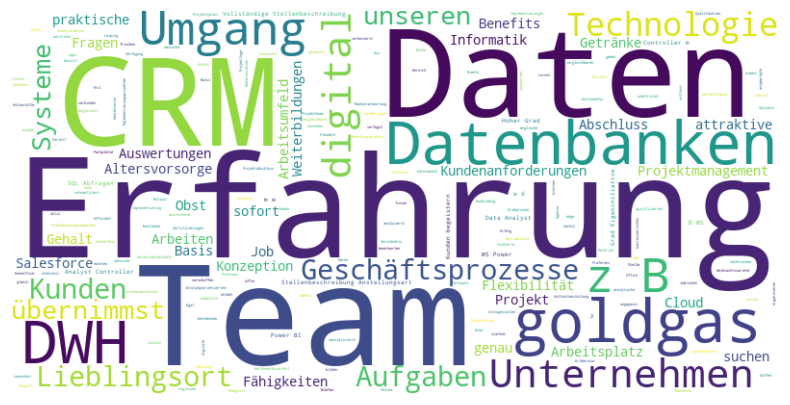

In [16]:
# Sammeln Sie alle Wörter aus den top_10_similar_descriptions
all_words = ' '.join(desc1 + ' ' + desc2 for _, desc1, desc2 in top_10_similar_descriptions)

# Erstellen Sie die Word-Cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(all_words)

# Zeige die Word-Cloud an
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()